# Entrenamineto y evaluacón de modelos

In [1]:
import os
import re

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model._logistic import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    make_scorer, f1_score, precision_score, recall_score, roc_auc_score
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from config import DATA_PATH, MODELS_PATH, VISUALIZATIONS_PATH
from notebooks.src.vectorizers import CustomTfidfVectorizer

In [2]:
TESTSETS = os.path.join(MODELS_PATH, "testsets")

## Carga de datos

In [3]:
data_path = os.path.join(DATA_PATH, "session_speech.csv")
data = pd.read_csv(data_path, converters={"speech_lemma_pos":eval})
data.columns

Index(['name', 'vote', 'senator', 'province', 'party', 'party_family',
       'speaker', 'speech', 'speech_preprocessed', 'speech_lemmas',
       'speech_pos', 'speech_lemma_pos', 'speech_preprocessed_count',
       'speech_preprocessed_count_unique', 'speech_lemmas_count',
       'speech_lemmas_count_unique', 'speech_pos_count',
       'speech_pos_count_unique', 'speech_lemma_pos_count_unique'],
      dtype='object')

In [4]:
data = (
    data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
    .reset_index(drop=True)
    .assign(
        speech_lemma_pos=lambda x: x.speech_lemma_pos.apply(
            lambda z: " ".join(["_".join(i) for i in z])
        )
    )
)
data[["speech_lemma_pos", "vote"]]

,speech_lemma_pos,vote
0,hacer_VERB año_NOUN tener_VERB una_DET sesión_...,positivo
1,gracia_NOUN señor_NOUN presidente_NOUN hoy_ADV...,negativo
2,como_SCONJ ir_VERB a_ADP pedir_VERB la_DET ins...,negativo
3,gracia_NOUN presidenta_NOUN nuevamente_ADV yo_...,negativo
4,gracia_NOUN señora_NOUN presidenta_NOUN realme...,negativo
...,...,...
194,gracia_NOUN presidenta_NOUN antes_ADV de_ADP c...,positivo
195,mucha_ADJ gracia_NOUN señora_NOUN presidenta_N...,positivo
196,ya_ADV presidenta_NOUN,positivo
197,en_ADP cuanto_ADJ al_ADP artículo_NOUN propone...,positivo


In [5]:
data.vote.value_counts(normalize=True)

vote
positivo    0.557789
negativo    0.442211
Name: proportion, dtype: float64

## Preprocesamiento

In [6]:
INDEX = os.path.join(MODELS_PATH, "index")
X_train_index = (
    pd
    .read_csv(os.path.join(INDEX, f"X_train_index.csv"), header=None, index_col=0)
    .index
)
X_test_index = (
    pd
    .read_csv(os.path.join(INDEX, f"X_test_index.csv"), header=None, index_col=0)
    .index
)
X_train_index.shape, X_test_index.shape

((159,), (40,))

In [7]:
le = joblib.load(os.path.join(MODELS_PATH, "labelencoder.pkl"))

data["target"] = le.fit_transform(data.vote)
data.target.unique()

array([1, 0])

In [8]:
train, test = data.loc[X_train_index], data.loc[X_test_index] 

X_train, y_train = train.speech_lemma_pos, train.target
X_test, y_test= test.speech_lemma_pos, test.target

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((159,), (159,), (40,), (40,))

## Selección de hiperparámetros

In [9]:
SEED = 6300

In [25]:
pipeline = Pipeline([
    ("vectorizer", CustomTfidfVectorizer(positive_values=1, dimension=300, log_idf=True)),
    ("clf", LogisticRegression(random_state=SEED))
])

score_methods = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scoring_method = {
    "accuracy": "accuracy",
    "f1": "f1",
    "f1_weighted": make_scorer(f1_score, average="weighted"),
    "f1_macro": make_scorer(f1_score, average="macro"),
    "precision": make_scorer(precision_score),
    #"precision_weighted": make_scorer(precision_score, average="weighted"),
    #"precision_macro": make_scorer(precision_score, average="macro"),
    "recall": make_scorer(recall_score),
    #"recall_weighted": make_scorer(recall_score, average="weighted"),
    #"recall_macro": make_scorer(recall_score, average="macro"),
    #"roc_auc_weighted": make_scorer(roc_auc_score, average="weighted"),
    #"roc_auc_macro": make_scorer(roc_auc_score, average="macro"),
}

class_weights = (
    y_train.value_counts(normalize=True).apply(lambda x: round(x,3)).to_dict()
)

In [26]:
y_train.value_counts(normalize=True).apply(lambda x: round(x,3)).to_dict()

{1: 0.56, 0: 0.44}

In [76]:
gs = GridSearchCV(
    estimator=pipeline,
    param_grid={
        "clf__penalty": [None, "l1", "l2"],
        "clf__C": [0.1, 0.5, 1, 2],
        "clf__class_weight": [None, "balanced", class_weights]
    },
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    refit="f1",
    scoring=scoring_method
)
gs.fit(X_train, y_train)

/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/macarena/.pyenv/v

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        CustomTfidfVectorizer(log_idf=True,
                                                              positive_values=1)),
                                       ('clf',
                                        LogisticRegression(random_state=6300))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 0.5, 1, 2],
                         'clf__class_weight': [None, 'balanced',
                                               {0: 0.44, 1: 0.56}],
                         'clf__penalty': [None, 'l1', 'l2']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'f1_macro': make_scorer(f1_score, average=macro),
                      'f1_weighted': make_scorer(f1_score, average=weighted),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [77]:
PARAMS = os.path.join(MODELS_PATH, "parameters_selection")
os.makedirs(PARAMS, exist_ok=True)

FILE = os.path.join(PARAMS, "gridsearch.joblib")
_ = joblib.dump(gs, FILE, compress=True)

In [78]:
gs.best_params_

{'clf__C': 0.1, 'clf__class_weight': {1: 0.56, 0: 0.44}, 'clf__penalty': None}

In [97]:
results = pd.DataFrame(gs.cv_results_)
for c in results.sort_values(by="rank_test_f1", ascending=True).loc[0]:
    print(c)

1.2961233139038086
0.8480607534832346
0.07260432243347167
0.066063757075277
0.1
None
None
{'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': None}
0.65625
0.65625
0.8125
0.75
0.6774193548387096
0.7104838709677419
0.06155437073605544
5
0.9763779527559056
0.9606299212598425
0.968503937007874
0.968503937007874
0.9765625
0.9701156496062993
0.005932159775308613
0.717948717948718
0.6666666666666666
0.8333333333333334
0.7999999999999999
0.6875
0.7410897435897436
0.06469228736648157
10
0.9784172661870503
0.9645390070921985
0.971830985915493
0.971830985915493
0.979020979020979
0.9731278448262428
0.005288455892977835
0.6488461538461539
0.657258064516129
0.8125
0.7416666666666666
0.6780913978494624
0.7076724565756825
0.06167917644555857
5
0.9764311522367178
0.9606645149397749
0.968503937007874
0.968503937007874
0.976584256451513
0.9701375595287507
0.005937090689115092
0.6389743589743591
0.6559139784946236
0.8095238095238095
0.7333333333333333
0.6770833333333333
0.7029657627318917
0.062057

In [98]:
results["params"] = (
    results
    .filter(regex="params")
    .params
    .apply(
        lambda x: ", ".join([f'{re.sub("clf__","",k)}={v}' for k, v in x.items()])
    )
)

rank_columns = results.filter(regex="rank_").columns.to_list()
params_columns = results.filter(regex="params").columns.to_list()
mean_test_columns = results.filter(regex="mean_test").columns.to_list()
std_test_columns = results.filter(regex="std_test").columns.to_list()

print(
    (
        results
        .pivot_table(index=params_columns, values=mean_test_columns)
        .applymap(lambda x: round(x, 3))
        .reset_index()
        .rename(columns={
            "params": "Parámetros",
            **{
                col: col.replace("mean_test_","").replace("_", " ").capitalize()
                for col in results[mean_test_columns].columns
            }
        })
        [["Parámetros","Accuracy","Precision","Recall","F1","F1 macro","F1 weighted"]]
        .style
        .highlight_max(axis=0, color="blue")
        .highlight_min(axis=0, color="orange")
        .to_latex()
    )
    .replace("background-colorblue ","cellcolor{highlight-blue!60}")
    .replace("background-colororange ","cellcolor{highlight-orange!60}")
    .replace(r"000","")
)

\begin{tabular}{llrrrrrr}
 & Parámetros & Accuracy & Precision & Recall & F1 & F1 macro & F1 weighted \\
0 & \cellcolor{highlight-orange!60}C=0.1, class_weight=None, penalty=None & 0.710 & 0.739 & 0.752 & 0.741 & 0.703 & 0.708 \\
1 & C=0.1, class_weight=None, penalty=l2 & 0.698 & 0.709 & 0.786 & 0.743 & 0.686 & 0.693 \\
2 & C=0.1, class_weight=balanced, penalty=None & 0.710 & 0.733 & 0.762 & 0.742 & 0.701 & 0.706 \\
3 & C=0.1, class_weight=balanced, penalty=l2 & 0.679 & \cellcolor{highlight-blue!60}0.786 & 0.595 & 0.674 & 0.678 & 0.678 \\
4 & C=0.1, class_weight={1: 0.56, 0: 0.44}, penalty=None & \cellcolor{highlight-blue!60}0.717 & 0.728 & 0.797 & \cellcolor{highlight-blue!60}0.759 & \cellcolor{highlight-blue!60}0.706 & \cellcolor{highlight-blue!60}0.712 \\
5 & C=0.1, class_weight={1: 0.56, 0: 0.44}, penalty=l2 & \cellcolor{highlight-orange!60}0.616 & \cellcolor{highlight-orange!60}0.607 & \cellcolor{highlight-blue!60}0.898 & 0.723 & \cellcolor{highlight-orange!60}0.541 & \cellcolor{h

In [116]:
test_f1_columns = results.filter(regex=r"test_f1$").columns.to_list()
split_test_f1_columns = list(filter(lambda x: x.startswith("split"), test_f1_columns))

f1_results = (
    results.loc[[0,2,3,24],test_f1_columns+params_columns]
    .sort_values(by=["rank_test_f1","params"])
    .melt(
        id_vars=params_columns+["mean_test_f1", "std_test_f1"],
        value_vars=split_test_f1_columns,
        var_name="measure"
    )
)

/tmp/ipykernel_314715/3077273135.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels([


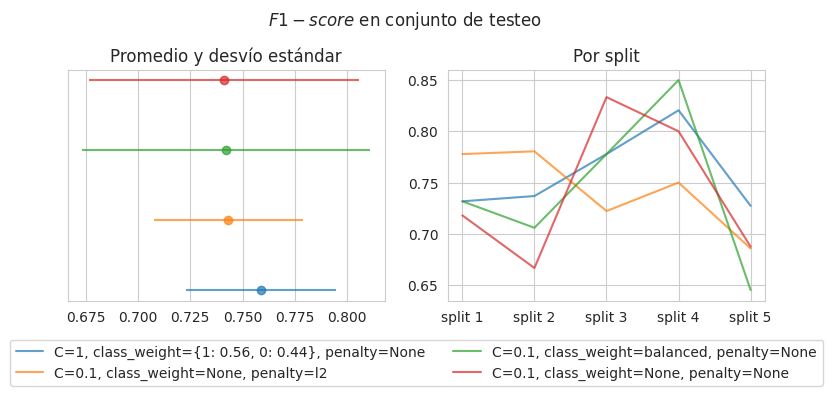

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(9,3))

for _, row in f1_results.drop_duplicates(["mean_test_f1","std_test_f1"],keep="first").iterrows():
    axs[0].errorbar(
        x=row.mean_test_f1,
        xerr=row.std_test_f1,
        y=row.params,
        fmt="o",
        label=row.params,
        alpha=.7
    )

sns.lineplot(f1_results, x="measure", y="value", hue="params", alpha=.7)
    
axs[0].set_yticks([])
axs[0].set_xlabel("")
axs[0].set_title("Promedio y desvío estándar")
axs[1].set_ylabel("")
axs[1].set_xticklabels([
    "split {n}".format(n=int(re.search(r'\d+', label.get_text()).group())+1)
    for label in axs[1].get_xticklabels()
])
axs[1].set_xlabel("")
axs[1].set_title("Por split")
title = fig.suptitle(f"$F1-score$ en conjunto de testeo", y=1.08)
lgd = plt.legend(loc="lower center", bbox_to_anchor=(-0.1, -0.4), ncol=2)

FOLDER = os.path.join(VISUALIZATIONS_PATH, "parameters_selection")
os.makedirs(FOLDER, exist_ok=True)
out_file = os.path.join(FOLDER, f"f1_by_split.png")
fig.savefig(
    out_file, bbox_extra_artists=[lgd,title], bbox_inches='tight'
)

## Reajuste

In [120]:
model = gs.best_estimator_.fit(X_train, y_train)

/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [121]:
MODEL = os.path.join(MODELS_PATH, "model")
os.makedirs(MODEL, exist_ok=True)

FILE = os.path.join(MODEL, "best_model.joblib")
_ = joblib.dump(model, FILE, compress=True)

## Evaluación

In [122]:
predictions = dict()

for method in ["predict", "predict_proba", "predict_log_proba"]:
    if hasattr(model, method):
        key = method.replace("predict_", "").strip()
        predictions.update(
            {f"y_hat_{key}": getattr(model, method)(X_test).tolist()}
        )

/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1413: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


In [123]:
import json

with open(os.path.join(MODEL, "predictions.json"), "w") as f:
    json.dump(predictions, f, ensure_ascii=False, indent=4)


## Reportes

In [124]:
print(classification_report(y_test, predictions["y_hat_predict"]))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85        18
           1       0.84      0.95      0.89        22

    accuracy                           0.88        40
   macro avg       0.89      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40



In [125]:
classification_report(y_test, predictions["y_hat_predict"], output_dict=True)

{'0': {'precision': 0.9333333333333333,
  'recall': 0.7777777777777778,
  'f1-score': 0.8484848484848485,
  'support': 18.0},
 '1': {'precision': 0.84,
  'recall': 0.9545454545454546,
  'f1-score': 0.8936170212765958,
  'support': 22.0},
 'accuracy': 0.875,
 'macro avg': {'precision': 0.8866666666666667,
  'recall': 0.8661616161616161,
  'f1-score': 0.8710509348807222,
  'support': 40.0},
 'weighted avg': {'precision': 0.882,
  'recall': 0.875,
  'f1-score': 0.8733075435203095,
  'support': 40.0}}

## Visualizaciones

In [126]:
colors = sns.color_palette()[:2][::-1]
colors

[(1.0, 0.4980392156862745, 0.054901960784313725),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

In [127]:
import matplotlib

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

In [128]:
def plot_confusion_matrix(cm, title, file_name=None):
    fig, ax = plt.subplots(figsize=(5,4))
    vmin, vmax = 0, int(cm.sum()/2)
    ticks = list(range(vmin, vmax+1, 2))
    sns.heatmap(
        cm, annot=True, cmap=cmap, alpha=.7, ax=ax,
        vmin=vmin, vmax=vmax,
        annot_kws={"color":"black", "size": 12},
        cbar_kws={"ticks": ticks},
        xticklabels=["En contra", "A favor"], yticklabels=["En contra", "A favor"]
    )
    #ax.set_title(title)
    ax.set_xlabel("Valores predichos")
    ax.set_ylabel("Valores esperados")
    if file_name:
        FOLDER = os.path.join(VISUALIZATIONS_PATH, "models")
        os.makedirs(FOLDER, exist_ok=True)
        out_file = os.path.join(FOLDER, f"{file_name}.png")
        fig.savefig(out_file)

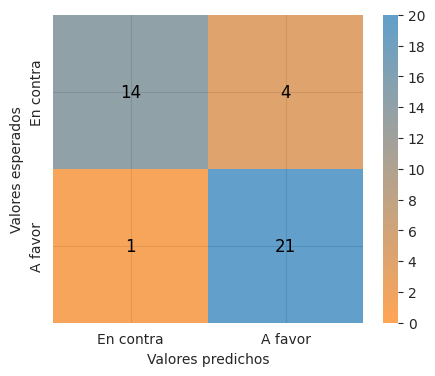

In [129]:
cm = confusion_matrix(y_test, predictions["y_hat_predict"])
plot_confusion_matrix(cm, title="Matriz de confus", file_name="confussion_matrix")

In [130]:
sns.color_palette().as_hex()[0]

'#1f77b4'

In [131]:
from copy import deepcopy

def plot_lr_weights(df: pd.DataFrame, title:str, file_name:str=None):
    df_copy = deepcopy(df)
    df_copy.loc[df_copy.coef >= 0, "weight"] = "pos"
    df_copy.loc[df_copy.coef < 0, "weight"] = "neg"
    fig, ax = plt.subplots(figsize=(6,3))
    sns.histplot(
        data = df_copy,
        x="coef",
        hue="weight",
        bins=30,
        ax=ax
    )
    ax.set_xlabel("")
    ax.set_ylabel("Observaciones")
    ax.get_legend().set_title("Pesos")
    fig.suptitle(title)
    if file_name:
        FOLDER = os.path.join(VISUALIZATIONS_PATH, "models")
        os.makedirs(FOLDER, exist_ok=True)
        out_file = os.path.join(FOLDER, f"{file_name}.png")
        fig.savefig(
            out_file, bbox_extra_artists=[title]
        )

def plot_lr_weights_barplot(
        df: pd.DataFrame,
        title:str,
        n: int = 25,
        file_name:str=None
    ):
    fig, axs = plt.subplots(1, 2, figsize=(9,9))
    sns.barplot(
        df[df.coef<0].nsmallest(n, columns=["coef"], keep="all"),
        x = "coef", y = "word",
        ax=axs[0],
        color="#1f77b4",
        alpha=.7
    )
    axs[0].set_title("Coeficientes negativos")
    axs[0].set_ylabel("")
    axs[0].set_xlabel("Magnitudd")
    sns.barplot(
        df[df.coef>=0].nlargest(n, columns=["coef"], keep="all"),
        x = "coef", y = "word",
        ax=axs[1],
        color="#1f77b4",
        alpha=.7
    )
    axs[1].set_title("Coeficientes positivos")
    axs[1].yaxis.tick_right()
    axs[1].set_ylabel("")
    axs[1].set_xlabel("Magnitudd")
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    if file_name:
        FOLDER = os.path.join(VISUALIZATIONS_PATH, "models")
        os.makedirs(FOLDER, exist_ok=True)
        out_file = os.path.join(FOLDER, f"{file_name}.png")
        fig.savefig(
            out_file, bbox_extra_artists=[title]
        )

In [132]:
len(model.steps[0][1].vocabulary)

299

In [133]:
weights = (pd.DataFrame({
    "word": model.steps[0][1].vocabulary,
    "coef": model.steps[1][1].coef_[0]
}))

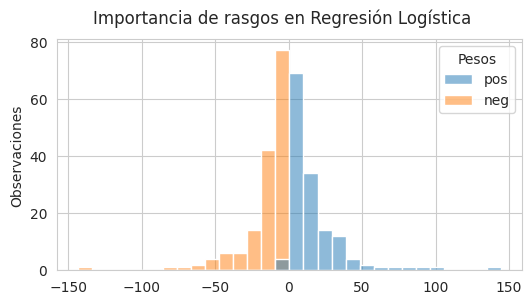

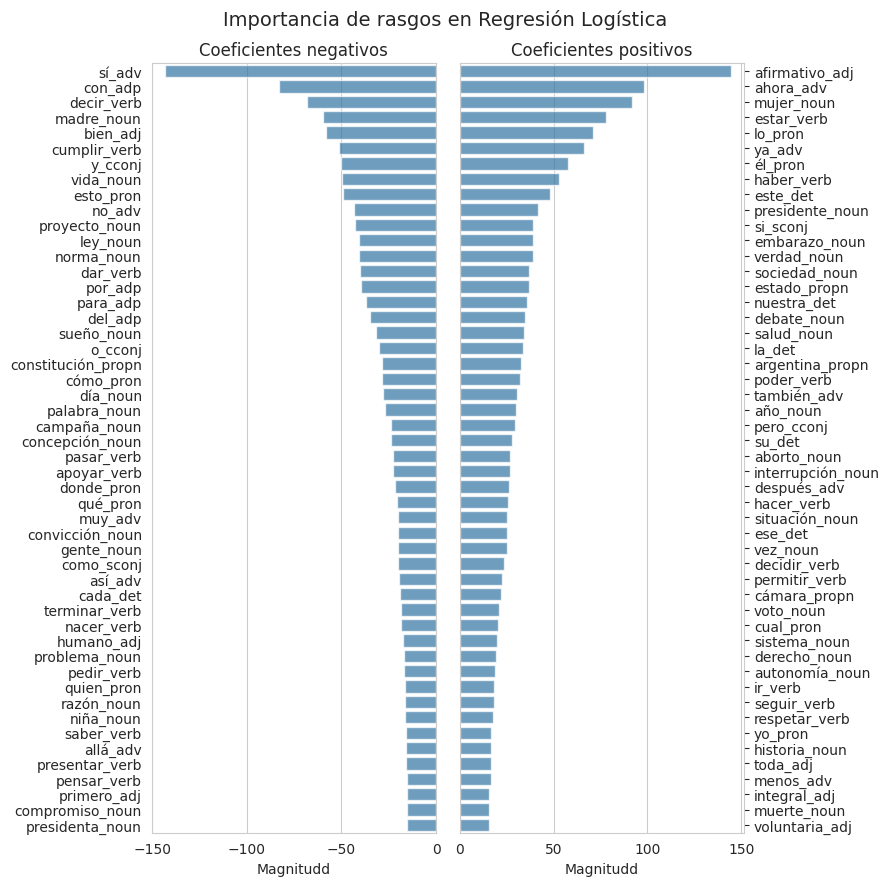

In [134]:
plot_lr_weights(
    weights,
    title=f"Importancia de rasgos en Regresión Logística",
    file_name=f"lr_feature_importance_{key}"
)
plot_lr_weights_barplot(
    weights,
    title=f"Importancia de rasgos en Regresión Logística",
    file_name=f"lr_feature_importance_barplot_{key}",
    n=50
)